# Todolist
- Gunakan Model yang Lebih Maju
- Membersihkan teks dari tanda baca yang tidak perlu atau melakukan tokenisasi yang lebih tepat
- Penyaringan atau pemrosesan lanjutan untuk memastikan bahwa jawaban yang dihasilkan relevan dan bermakna
- Perluas dataset pelatihan dengan pertanyaan yang lebih bervariasi dan relevan sehingga model memiliki lebih banyak informasi untuk merespons pertanyaan yang mungkin tidak ada dalam dataset

## Install package

In [1]:
# %pip install tensorflow pandas transformers datasets tf-keras sklearn

## Import package

In [2]:
import pandas as pd
from datasets import Dataset
from transformers import TFBertForQuestionAnswering, BertTokenizerFast, DefaultDataCollator, create_optimizer
from transformers import TrainingArguments, Trainer
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most TensorFlow messages
tf.get_logger().setLevel('ERROR')

In [4]:
# Ensure tf_keras is installed
try:
    import tf_keras
except ImportError:
    print("tf-keras is not installed. Installing now...")
    %pip install tf-keras

In [5]:
# Load the dataset
df = pd.read_csv('../data/final_dataset.csv')
dataset = Dataset.from_pandas(df)
print(df.head())

   id                                            context  \
0   1  ROI atau Return on Investment adalah rasio keu...   
1   2  EBITDA atau Earnings Before Interest, Taxes, D...   
2   3  Leverage dalam konteks finansial adalah penggu...   
3   4  Diversifikasi adalah strategi investasi yang m...   
4   5  Volatilitas adalah ukuran seberapa besar harga...   

                 question                                             answer  \
0            Apa itu ROI?  ROI atau Return on Investment adalah rasio keu...   
1         Apa itu EBITDA?  EBITDA atau Earnings Before Interest, Taxes, D...   
2       Apa itu Leverage?  Leverage dalam konteks finansial adalah penggu...   
3  Apa itu Diversifikasi?  Diversifikasi adalah strategi investasi yang m...   
4    Apa itu Volatilitas?  Volatilitas adalah ukuran seberapa besar harga...   

   answer_start  
0             0  
1             0  
2             0  
3             0  
4             0  


In [6]:
print(df.columns)

Index(['id', 'context', 'question', 'answer', 'answer_start'], dtype='object')


In [7]:
# Load the tokenizer and model for fine-tuning
model_name = "Rifky/Indobert-QA"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = TFBertForQuestionAnswering.from_pretrained(model_name)

c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch 

In [8]:
# Load pre-trained model for generating answers when context is not found
pretrained_model = TFBertForQuestionAnswering.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [9]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=256,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answer"]
    start_positions = []
    end_positions = []

    for i, (answer, offset) in enumerate(zip(answers, offset_mapping)):
        start_char = examples["answer_start"][i]
        end_char = start_char + len(answer)

        sequence_ids = inputs.sequence_ids(i)

        context_start = 0
        while sequence_ids[context_start] != 1:
            context_start += 1
        context_end = context_start
        while context_end < len(sequence_ids) and sequence_ids[context_end] == 1:
            context_end += 1
        context_end -= 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_idx = context_start
            while start_idx <= context_end and offset[start_idx][0] <= start_char:
                start_idx += 1
            start_positions.append(start_idx - 1)

            end_idx = context_start
            while end_idx <= context_end and offset[end_idx][1] < end_char:
                end_idx += 1
            end_positions.append(end_idx - 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [10]:
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)
print(tokenized_datasets)

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 490
})


In [11]:
# Check the first few elements
for item in tokenized_datasets:
    print(item)
    break

{'input_ids': [3, 2064, 1570, 3057, 939, 35, 4, 3057, 939, 1647, 22739, 2587, 23270, 1581, 10357, 4994, 1647, 5938, 1497, 6023, 1542, 5737, 5646, 1973, 3592, 5737, 18, 3057, 939, 2633, 2318, 1559, 16029, 11311, 1647, 17479, 13163, 2170, 5737, 1647, 1559, 13622, 11311, 1841, 5737, 1497, 2748, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
# Split the tokenized dataset into train and validation sets
train_test_split = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 441
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 49
})


In [13]:
training_args = TrainingArguments(
    output_dir="../models/fine_tuned_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='../logs',
    logging_steps=10,
    max_steps=1000,
)

In [14]:
# Create a data collator
data_collator = DefaultDataCollator(return_tensors="tf")

In [15]:
def create_tf_dataset(tokenized_datasets):
    def generator():
        for example in tokenized_datasets:
            yield (
                {
                    'input_ids': example['input_ids'],
                    'attention_mask': example['attention_mask']
                },
                {
                    'start_positions': example['start_positions'],
                    'end_positions': example['end_positions']
                }
            )

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            {
                'input_ids': tf.TensorSpec(shape=(256,), dtype=tf.int32),
                'attention_mask': tf.TensorSpec(shape=(256,), dtype=tf.int32)
            },
            {
                'start_positions': tf.TensorSpec(shape=(), dtype=tf.int32),
                'end_positions': tf.TensorSpec(shape=(), dtype=tf.int32)
            }
        )
    ).batch(4)

In [16]:
train_tf_dataset = create_tf_dataset(train_dataset)
val_tf_dataset = create_tf_dataset(val_dataset)

In [17]:
for batch in train_dataset.take(1):
    print(batch)

{'input_ids': [3, 2064, 1570, 10357, 4392, 7501, 35, 4, 10357, 4392, 7501, 1581, 9740, 1899, 2661, 4392, 1501, 2661, 7501, 18, 10357, 1540, 2318, 1617, 7405, 1559, 16029, 2692, 5646, 1899, 2048, 6706, 6825, 1676, 1501, 2026, 3028, 5737, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
for batch in val_dataset.take(1):
    print("Validation Batch")
    print(batch)

Validation Batch
{'input_ids': [3, 2064, 1570, 4644, 3835, 12517, 35, 4, 4644, 3835, 12517, 1581, 4644, 1497, 8588, 1897, 8003, 1501, 3625, 3835, 12517, 18, 4644, 1540, 23263, 1617, 1990, 1995, 1501, 2318, 1559, 6207, 2050, 1501, 8348, 5958, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
# Define custom loss function


def custom_loss(y_true, y_pred):
    
    y_pred_array = y_pred.numpy()
    y_true_array = y_true.numpy()

    # Melihat bentuk array
    print("Shape of y_pred:", y_pred_array.shape)
    print("Shape of y_true:", y_true_array.shape)
    
    start_positions = tf.gather(tf.reshape(y_pred[0], [-1, tf.shape(y_pred[0])[-1]]), y_true[:, 0], batch_dims=1)
    end_positions = tf.gather(tf.reshape(y_pred[1], [-1, tf.shape(y_pred[1])[-1]]), y_true[:, 1], batch_dims=1)
    
    start_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true[:, 0], start_positions, from_logits=True
    )
    
    end_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true[:, 1], end_positions, from_logits=True
    )
    
    return (start_loss + end_loss) / 2.0


# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_args.learning_rate),
              loss=custom_loss)
model.fit(train_tf_dataset, validation_data=val_tf_dataset, epochs=training_args.num_train_epochs)

# Evaluate the model
results = model.evaluate(val_tf_dataset)
print(f"Validation loss: {results}")

# Predict and visualize the results
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

# Get predictions
predictions = model.predict(val_tf_dataset)

# Extracting predicted start and end positions from the model's output
predicted_start_positions = tf.argmax(predictions[0], axis=-1)
predicted_end_positions = tf.argmax(predictions[1], axis=-1)

# Convert tensors to numpy arrays for confusion matrix plotting
predicted_start_positions = predicted_start_positions.numpy()
predicted_end_positions = predicted_end_positions.numpy()

# Get true start and end positions
true_start_positions = val_dataset["start_positions"]
true_end_positions = val_dataset["end_positions"]

# Ensure matching lengths
true_start_positions = true_start_positions[:len(predicted_start_positions)]
true_end_positions = true_end_positions[:len(predicted_end_positions)]

# Plot confusion matrix for start positions
plot_confusion_matrix(true_start_positions, predicted_start_positions, labels=list(range(len(tokenizer))))

# Plot confusion matrix for end positions
plot_confusion_matrix(true_end_positions, predicted_end_positions, labels=list(range(len(tokenizer))))

# Saving the model

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


AttributeError: in user code:

    File "c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  *
        outputs = model.train_step(data)
    File "c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\transformers\modeling_tf_utils.py", line 1647, in train_step  *
        loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    File "c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\tf_keras\src\engine\compile_utils.py", line 277, in __call__  *
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\tf_keras\src\losses.py", line 143, in __call__  *
        losses = call_fn(y_true, y_pred)
    File "c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\tf_keras\src\losses.py", line 270, in call  *
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\alifs\AppData\Local\Temp\ipykernel_11096\2119429720.py", line 6, in custom_loss  *
        y_pred_array = y_pred.numpy()

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


In [37]:
def custom_loss(y_true, y_pred):
    tf.print('y_true:', y_true)
    tf.print('y_pred:', y_pred)
    
    y_true_start, y_true_end = y_true
    y_pred_start, y_pred_end = y_pred

    tf.print('y_true_start shape:', tf.shape(y_true_start))
    tf.print('y_true_end shape:', tf.shape(y_true_end))
    tf.print('y_pred_start shape:', tf.shape(y_pred_start))
    tf.print('y_pred_end shape:', tf.shape(y_pred_end))
    
    start_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_start, y_pred_start, from_logits=True)
    end_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_end, y_pred_end, from_logits=True)

    
    return (start_loss + end_loss) / 2

In [38]:
def compute_start_logits_accuracy(y_true, y_pred):
    y_true_start, _ = y_true
    y_pred_start, _ = y_pred
    return tf.keras.metrics.sparse_categorical_accuracy(y_true_start, y_pred_start)

def compute_end_logits_accuracy(y_true, y_pred):
    _, y_true_end = y_true
    _, y_pred_end = y_pred
    return tf.keras.metrics.sparse_categorical_accuracy(y_true_end, y_pred_end)

In [39]:
# Create optimizer and compile model
num_train_steps = len(train_dataset) * training_args.num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=training_args.learning_rate,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=training_args.weight_decay,
)

In [40]:
# Compile model with the correct metrics
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=custom_loss,
              metrics={
                  'start_logits_accuracy': compute_start_logits_accuracy,
                  'end_logits_accuracy': compute_end_logits_accuracy
              })

## Callbacks for logging accuracy and loss

In [ ]:
# class LossAccuracyF1Logger(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         super(LossAccuracyF1Logger, self).__init__()
#         self.validation_data = validation_data
#         self.epoch_loss = []
#         self.epoch_start_accuracy = []
#         self.epoch_end_accuracy = []
#         self.epoch_f1 = []

#     def on_epoch_end(self, epoch, logs=None):
#         self.epoch_loss.append(logs['loss'])
#         self.epoch_start_accuracy.append(logs['start_logits_accuracy'])
#         self.epoch_end_accuracy.append(logs['end_logits_accuracy'])
        
#         # Calculate F1 score on validation data
#         predictions, true_labels = [], []
#         for batch in self.validation_data:
#             inputs = {'input_ids': batch['input_ids'], 'attention_mask': batch['attention_mask']}
#             true_labels.extend(batch['start_positions'].numpy())
#             start_logits, end_logits = self.model.predict(inputs)
#             pred_start = tf.argmax(start_logits, axis=-1).numpy()
#             pred_end = tf.argmax(end_logits, axis=-1).numpy()
#             predictions.extend(pred_start)
        
#         f1 = f1_score(true_labels, predictions, average='weighted')
#         self.epoch_f1.append(f1)
        
#         # Plot the metrics
#         self.plot()
        
#     def plot(self):
#         plt.figure(figsize=(18, 5))
#         plt.subplot(1, 4, 1)
#         plt.plot(self.epoch_loss, label='Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.subplot(1, 4, 2)
#         plt.plot(self.epoch_start_accuracy, label='Start Accuracy')
#         plt.xlabel('Epoch')
#         plt.ylabel('Start Accuracy')
#         plt.legend()
#         plt.subplot(1, 4, 3)
#         plt.plot(self.epoch_end_accuracy, label='End Accuracy')
#         plt.xlabel('Epoch')
#         plt.ylabel('End Accuracy')
#         plt.legend()
#         plt.subplot(1, 4, 4)
#         plt.plot(self.epoch_f1, label='F1 Score')
#         plt.xlabel('Epoch')
#         plt.ylabel('F1 Score')
#         plt.legend()
#         plt.show()
        
#     def _implements_train_batch_hooks(self):
#         return False


In [41]:
class LossAccuracyLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(LossAccuracyLogger, self).__init__()
        self.validation_data = validation_data
        self.epoch_loss = []
        self.epoch_start_accuracy = []
        self.epoch_end_accuracy = []
        self.val_loss = []
        self.val_start_accuracy = []
        self.val_end_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_loss.append(logs['loss'])
        self.epoch_start_accuracy.append(logs['start_logits_accuracy'])
        self.epoch_end_accuracy.append(logs['end_logits_accuracy'])

        val_loss, val_start_accuracy, val_end_accuracy = self.evaluate_validation()
        self.val_loss.append(val_loss)
        self.val_start_accuracy.append(val_start_accuracy)
        self.val_end_accuracy.append(val_end_accuracy)

        self.plot_metrics()

    def evaluate_validation(self):
        val_loss = 0
        val_start_accuracy = 0
        val_end_accuracy = 0
        for batch in self.validation_data:
            inputs = {'input_ids': batch[0]['input_ids'], 'attention_mask': batch[0]['attention_mask']}
            start_positions, end_positions = batch[1]

            loss = self.model.evaluate(inputs, batch[1], verbose=0)
            val_loss += loss[0]
            val_start_accuracy += loss[1]
            val_end_accuracy += loss[2]

        val_loss /= len(self.validation_data)
        val_start_accuracy /= len(self.validation_data)
        val_end_accuracy /= len(self.validation_data)
        return val_loss, val_start_accuracy, val_end_accuracy

    def plot_metrics(self):
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Learning Curve - Loss')

        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_start_accuracy, label='Training Start Accuracy')
        plt.plot(self.val_start_accuracy, label='Validation Start Accuracy')
        plt.plot(self.epoch_end_accuracy, label='Training End Accuracy')
        plt.plot(self.val_end_accuracy, label='Validation End Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Learning Curve - Accuracy')

        plt.show()

    def on_train_end(self, logs=None):
        y_true = []
        y_pred = []
        for batch in self.validation_data:
            inputs = {'input_ids': batch[0]['input_ids'], 'attention_mask': batch[0]['attention_mask']}
            true_start, true_end = batch[1]
            start_logits, end_logits = model.predict(inputs)
            pred_start = tf.argmax(start_logits, axis=-1).numpy()
            pred_end = tf.argmax(end_logits, axis=-1).numpy()
            y_true.extend(true_start.numpy())
            y_true.extend(true_end.numpy())
            y_pred.extend(pred_start)
            y_pred.extend(pred_end)

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

In [44]:
# Gunakan experimental.gpu_options untuk mengatur pertumbuhan memori GPU
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Hanya alokasi memori yang diperlukan
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)


In [42]:
logger = LossAccuracyLogger(validation_data=val_tf_dataset)

In [43]:
# Set mixed precision policy and enable eager execution
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.run_functions_eagerly(True)

# Train model

In [44]:
try:
    model.fit(train_tf_dataset, epochs=training_args.num_train_epochs, callbacks=[logger])
except Exception as e:
    print(f"An error occurred during training: {e}")
    raise

y_true: [[13]
 [7]
 [13]
 [8]]
y_pred: [[-8.35542 -9.20482159 -9.25583267 ... -10.4150944 -9.50561333 -9.41956902]
 [-9.88490868 -9.41079426 -9.99605656 ... -9.8761549 -9.54917049 -9.99579811]
 [-7.74446583 -9.316679 -9.77689838 ... -10.3791056 -10.2641125 -9.57383728]
 [-9.57224274 -9.36782265 -9.32917213 ... -9.96795368 -9.62810898 -9.99006271]]
An error occurred during training: in user code:

    File "C:\Users\alifs\AppData\Local\Temp\ipykernel_5132\1234561693.py", line 5, in custom_loss  *
        y_true_start, y_true_end = y_true

    ValueError: too many values to unpack (expected 2)



ValueError: in user code:

    File "C:\Users\alifs\AppData\Local\Temp\ipykernel_5132\1234561693.py", line 5, in custom_loss  *
        y_true_start, y_true_end = y_true

    ValueError: too many values to unpack (expected 2)


# Cek nilai null

## Periksa Data Input:

In [84]:
from functools import reduce

# Periksa apakah ada nilai None dalam data input
def check_for_none(batch):
    for key, value in batch.items():
        if value is None:
            return True
    return False

# Gunakan reduce untuk menggabungkan hasil dari setiap batch menjadi satu nilai boolean
has_none = reduce(lambda x, y: x or y, train_dataset.map(check_for_none))

if has_none:
    print("Ada nilai None dalam data input.")
else:
    print("Tidak ada nilai None dalam data input.")


Tidak ada nilai None dalam data input.


## Periksa Kembali Proses Training:

In [85]:
print("Model summary:")
print(model.summary())

# Periksa definisi metrik
print("Daftar metrik yang didefinisikan untuk model:")
print(model.metrics_names)

Model summary:
Model: "tf_bert_for_question_answering_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109967616 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 109969154 (419.50 MB)
Trainable params: 109969154 (419.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Daftar metrik yang didefinisikan untuk model:
[]


## Periksa Definisi Model dan Metrik:

In [87]:
# Pastikan model telah diinisialisasi dengan benar
if model is None:
    print("Model belum diinisialisasi dengan benar.")
else:
    print("Model telah diinisialisasi.")

# Pastikan metrik telah diinisialisasi dengan benar
if any(metric is None for metric in [compute_start_logits_accuracy, compute_end_logits_accuracy]):
    print("Ada metrik yang belum diinisialisasi dengan benar.")
else:
    print("Semua metrik telah diinisialisasi dengan benar.")


Model telah diinisialisasi.
Semua metrik telah diinisialisasi dengan benar.


## Periksa Proses Pembelajaran:

In [176]:
try:
    gradients = tf.keras.backend.compute_gradients(model.loss, model.trainable_variables)
    if any(grad is None for grad, _ in gradients):
        print("Ada masalah dalam proses pembelajaran: beberapa parameter tidak memiliki gradien.")
    else:
        print("Proses pembelajaran berjalan dengan baik: semua parameter memiliki gradien.")
except Exception as e:
    print("Terjadi kesalahan saat memeriksa gradien:", e)

Terjadi kesalahan saat memeriksa gradien: module 'keras._tf_keras.keras.backend' has no attribute 'compute_gradients'


In [178]:
# Error analysis
# for example in train_dataset:
#     input_ids = tf.convert_to_tensor([example['input_ids']])
#     attention_mask = tf.convert_to_tensor([example['attention_mask']])
#     # Hapus pemanggilan model di sini
#     start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask, training=False)
#     start_index = tf.argmax(start_logits, axis=-1)[0].numpy()
#     end_index = tf.argmax(end_logits, axis=-1)[0].numpy()
#     predicted_answer = tokenizer.decode(input_ids[0][start_index:end_index + 1])
#     true_answer = example['answer']
#     # Hanya cetak hasil prediksi di sini
#     if predicted_answer != true_answer:
#         print("Question:", example['question'])
#         print("Predicted Answer:", predicted_answer)
#         print("True Answer:", true_answer)
#         print()

# Plot accuracy, loss, and F1 score

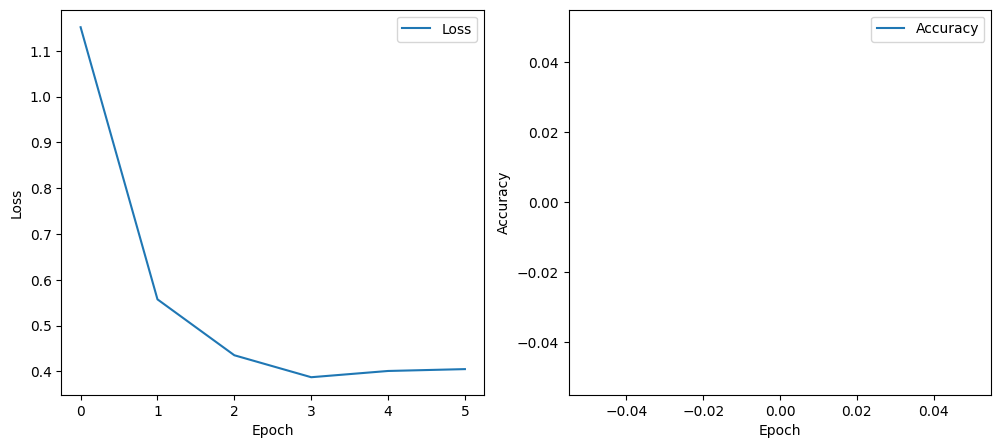

In [179]:
logger.plot()

In [291]:
# Function to answer a question using the fine-tuned model or the pretrained model
def answer_question(question, context, use_pretrained=False):
    if context is None:
        use_pretrained = True  # Use pretrained model if context is not available
    inputs = tokenizer(question, context, return_tensors="tf")
    if use_pretrained:
        outputs = pretrained_model(inputs)
    else:
        outputs = model(inputs)
    answer_start = tf.argmax(outputs.start_logits, axis=1).numpy()[0]
    answer_end = tf.argmax(outputs.end_logits, axis=1).numpy()[0] + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    return answer

In [292]:
# Function to find context based on the question using Jaccard similarity
def find_context_for_question(question, dataframe):
    max_matched_words = 0
    best_matched_context = None
    context_found = False

    # Iterate through the rows of the dataframe
    for _, row in dataframe.iterrows():
        if question.strip().lower() in row['question'].strip().lower():
            best_matched_context = row['context']
            context_found = True
            break  # Break the loop if a matching context is found

    # If no exact match is found, find the best matching context based on the number of common words
    if not context_found:
        for _, row in dataframe.iterrows():
            dataset_tokens = set(row['question'].strip().lower().split())
            matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
            if matched_words > max_matched_words:
                max_matched_words = matched_words
                best_matched_context = row['context']

    return best_matched_context, context_found

In [293]:
# Function to provide a recommendation when no answer is found in the dataset
def provide_recommendation():
    return ("Terima kasih atas pertanyaannya! Meskipun tidak ada jawaban langsung dari kami, berikut adalah "
            "beberapa rekomendasi umum untuk membantu keuangan anda:\n\n"
            "1. Mulailah dengan membuat anggaran dan mengelola pengeluaran Anda dengan cermat.\n"
            "2. Pertimbangkan untuk mencari peluang sampingan atau pekerjaan paruh waktu.\n"
            "3. Pelajari dan investasikan uang Anda dengan bijak. Mungkin Anda ingin mempertimbangkan untuk berinvestasi dalam saham, obligasi, atau properti.\n"
            "4. Kembangkan keterampilan yang bernilai tinggi dan pertimbangkan untuk memonetisasi hobi atau minat Anda.\n"
            "5. Jangan lupa untuk memiliki perencanaan keuangan jangka panjang, termasuk perencanaan pensiun dan perlindungan asuransi.\n\n"
            "Semoga ini membantu Anda memulai perjalanan keuangan Anda!")

In [303]:
# User input for the question
# user_question = input("Enter your financial question: ")
# user_question = "Apa itu EBITDA"
user_question = "apa nama ibu kota indonesia"

In [304]:
# Find context for the user's question
# context = find_context_for_question(user_question, df)
context, context_found = find_context_for_question(user_question, df)

In [305]:
# Function to find context based on the question
# Mendekati dataset
# Tidak disarankan karena halusinasi

def provide_recommendation_for_question(question):
    max_matched_words = 0
    best_matched_context = None

    # Iterate through the rows of the dataset
    for _, row in df.iterrows():
        dataset_tokens = set(row['question'].strip().lower().split())
        matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
        if matched_words > max_matched_words:
            max_matched_words = matched_words
            best_matched_context = row['context']

    if best_matched_context:
        return best_matched_context
    else:
        return provide_recommendation()

In [306]:
if context_found:
    # Get the answer to the user question using the found context
    answer = answer_question(user_question, context)
    print(f"Q: {user_question}\nA: {answer}")
else:
    # If context is not found, provide a recommendation based on the user's question
    answer = provide_recommendation_for_question(user_question)
    print(f"Q: {user_question}\nA: {answer}")

Q: apa nama ibu kota indonesia
A: Investasi pemerintah dalam proyek pembangunan ibu kota baru mencapai Rp150 triliun pada tahun 2023.


In [265]:
# Save the model at the end
# model.save_pretrained("../models/fine_tuned_model")
# tokenizer.save_pretrained("../models/fine_tuned_model")